# Data Science Challenge - Fleury
# 0. Importação das bibliotecas necessárias e definição de funções

In [1]:
# Bibliotecas básicas de sistema
import math, calendar, datetime
from IPython.display import Image
from IPython.core.display import HTML
import inflection

# Bibliotecas básicas de manipulação de dados
import pandas as pd
import numpy as np
from scipy import stats

# Biblioteca de machine learning
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from pyod.models.knn import KNN
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from boruta import BorutaPy

from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb

# Medir desempenho
from sklearn import metrics
from sklearn.model_selection import KFold

# Biblioteca de Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Limpar warning
import warnings; warnings.filterwarnings('ignore')
# Mostrar todas colunas
pd.set_option('display.max_columns', None)

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container{width:100% !important}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1. Descrição dos dados

In [3]:
df_raw = pd.read_csv('challenge/data/dados.csv', sep=';')
df_raw.head()

,Dia semana agendamento,Ano agendamento,Mes agendamento,Hora agendamento,Dia mes agendamento,Dia semana atendimento,Ano atendimento,Mes atendimento,Hora atendimento,Dia mes atendimento,Secao,Medico preferencial,Renda Provavel,MicroArea,Diretoria,Cod convenio,Codigo exame,Idade,Tempo medio de agendamento,Unidade,Bairro,Feminino,No Show,Unnamed: 23,Legenda
0,6,2019,8,8,18,3,2019,8,15,15,110,0,1028823,377,7,115,465530,39,2,VILLA LOBOS,4218,1,0,NaN,Show = 0
1,2,2019,11,7,6,0,2019,11,13,4,110,0,1028823,377,7,115,465530,39,1,VILLA LOBOS,4218,1,1,NaN,No Show = 1
2,5,2019,8,8,31,3,2019,8,15,15,36,0,1028823,377,7,115,465530,39,15,ITAIM,4218,1,0,NaN,NaN
3,4,2019,9,11,27,4,2019,9,8,27,110,1,489594,767,7,115,465530,49,0,HIGIENÓPOLIS,2169,1,0,NaN,NaN
4,4,2019,10,11,11,1,2019,10,17,1,110,0,31829,568,7,115,7244510,33,9,ALPHAVILLE,9638,1,0,NaN,NaN


## 1.1 Renaming columns

In [4]:
df1 = df_raw.copy()
cols_old = df1.columns

In [5]:
snakecase = lambda x: inflection.underscore(x)
df1.columns = list(map(snakecase, cols_old))

In [6]:
df1.columns

Index(['dia_semana_agendamento', 'ano_agendamento', 'mes_agendamento',
       'hora_agendamento', 'dia_mes_agendamento', 'dia_semana_atendimento',
       'ano_atendimento', 'mes_atendimento', 'hora_atendimento',
       'dia_mes_atendimento', 'secao', 'medico_preferencial', 'renda_provavel',
       'micro_area', 'diretoria', 'cod_convenio', 'codigo_exame', 'idade',
       'tempo_medio_de_agendamento', 'unidade', 'bairro', 'feminino',
       'no_show', 'unnamed:_23', 'legenda'],
      dtype='object')

## 1.2 Data dimensions

In [7]:
print('Número de linhas: {:,}'.format(df1.shape[0]).replace(",", " "))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 299 616
Número de colunas: 25


In [8]:
df1.dtypes

dia_semana_agendamento          int64
ano_agendamento                 int64
mes_agendamento                 int64
hora_agendamento                int64
dia_mes_agendamento             int64
dia_semana_atendimento          int64
ano_atendimento                 int64
mes_atendimento                 int64
hora_atendimento                int64
dia_mes_atendimento             int64
secao                           int64
medico_preferencial             int64
renda_provavel                  int64
micro_area                      int64
diretoria                       int64
cod_convenio                    int64
codigo_exame                    int64
idade                           int64
tempo_medio_de_agendamento      int64
unidade                        object
bairro                          int64
feminino                        int64
no_show                         int64
unnamed:_23                   float64
legenda                        object
dtype: object

## 1.3 Check N/A

In [9]:
df1.isna().sum()

dia_semana_agendamento             0
ano_agendamento                    0
mes_agendamento                    0
hora_agendamento                   0
dia_mes_agendamento                0
dia_semana_atendimento             0
ano_atendimento                    0
mes_atendimento                    0
hora_atendimento                   0
dia_mes_atendimento                0
secao                              0
medico_preferencial                0
renda_provavel                     0
micro_area                         0
diretoria                          0
cod_convenio                       0
codigo_exame                       0
idade                              0
tempo_medio_de_agendamento         0
unidade                            0
bairro                             0
feminino                           0
no_show                            0
unnamed:_23                   299616
legenda                       299614
dtype: int64

## 1.4 Fill N/A

Há duas colunas no final da tabela que não possuem informação. Vamos analisar o conteúdo delas e a possibilidade de sua eliminação

In [10]:
nullvalues = df1[df1.columns[-2:]].isnull().sum(axis = 0)
length = len(df1[df1.columns[-2:]])
print('O valor de nulos da penultima coluna é {}'.format(nullvalues[0]))
print('O valor de nulos da última coluna é {}'.format(nullvalues[1]))
print('O tamanho total das linhas é {}'.format(length))

O valor de nulos da penultima coluna é 299616
O valor de nulos da última coluna é 299614
O tamanho total das linhas é 299616


Pode-se concluir que pode-se eliminar as duas últimas colunas:

In [11]:
df1 = df1[df1.columns[:-2]]

Olhando os dados mais a fundo, percebemos que há um N/A no atributo idade, porém escrito como 999

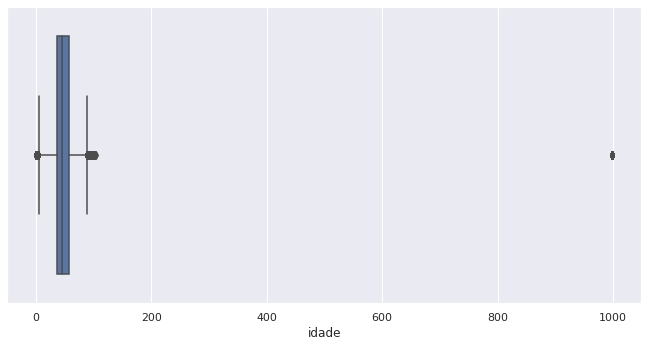

In [12]:
plt.subplot(2, 2, 1) # Multigrid para plotar num plt menor
sns.boxplot(df1['idade'])

Os atributos N/A de idade são substítuidos, portanto pela média das idades

In [13]:
avg_age = df1[(df1['idade']<200)].mean()['idade']
df1.loc[df1['idade'] > 200, 'idade'] = avg_age

## 1.5 Estatística descritiva

In [14]:
num_attributes = df1[['dia_semana_agendamento',
                   'ano_agendamento', 'mes_agendamento',
                   'hora_agendamento', 'dia_mes_agendamento', 'dia_semana_atendimento',
                   'ano_atendimento', 'mes_atendimento', 'hora_atendimento',
                   'dia_mes_atendimento', 'renda_provavel',
                   'idade', 'tempo_medio_de_agendamento']]

cat_attributes = df1[[*list(set(df1.columns) - set(num_attributes.columns))]]
cat_attributes.columns

Index(['medico_preferencial', 'micro_area', 'codigo_exame', 'no_show',
       'diretoria', 'unidade', 'feminino', 'bairro', 'cod_convenio', 'secao'],
      dtype='object')

### 1.5.1 Atributos quantitativos

In [15]:
# Centra Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,dia_semana_agendamento,0.0,6.0,6.0,2.681509e+00,3.0,1.773892e+00,0.036750,-1.137935
1,ano_agendamento,2019.0,2019.0,0.0,2.019000e+03,2019.0,0.000000e+00,0.000000,0.000000
2,mes_agendamento,8.0,11.0,3.0,9.407442e+00,9.0,1.087676e+00,0.079046,-1.289998
3,hora_agendamento,5.0,23.0,18.0,1.050765e+01,10.0,2.981927e+00,1.013507,0.429600
4,dia_mes_agendamento,1.0,31.0,30.0,1.518913e+01,15.0,8.504876e+00,0.125022,-1.072708
5,dia_semana_atendimento,0.0,6.0,6.0,2.065971e+00,2.0,1.604074e+00,0.369507,-0.765697
6,ano_atendimento,2019.0,2019.0,0.0,2.019000e+03,2019.0,0.000000e+00,0.000000,0.000000
7,mes_atendimento,5.0,11.0,6.0,9.202876e+00,9.0,1.128300e+00,-0.013936,-0.953073
8,hora_atendimento,5.0,23.0,18.0,1.308485e+01,13.0,3.678562e+00,0.232155,-0.881955
9,dia_mes_atendimento,1.0,31.0,30.0,1.530883e+01,15.0,8.917339e+00,0.129472,-1.178741


### 1.5.2 Atributos categóricos

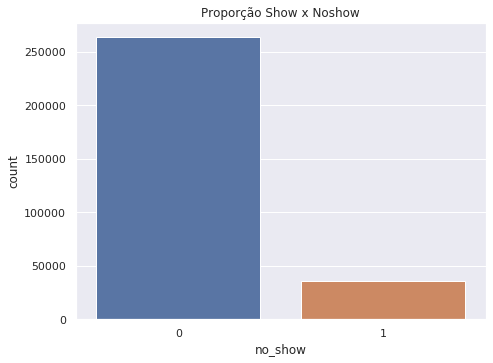

In [16]:
plt.subplot(2,3,1)
plt.title("Proporção Show x Noshow")
sns.countplot(df1['no_show'])

In [17]:
y_proportion = df1[df1['no_show']==1]['no_show'].sum() / df1['no_show'].count()
print('Pela proporção de show e não show, o desempenho deve ser medido sobre o no_show, pois um algoritmo que só devolva 0 já teria um acerto de {}%'.format(round(100-y_proportion*100, 2)))

Pela proporção de show e não show, o desempenho deve ser medido sobre o no_show, pois um algoritmo que só devolva 0 já teria um acerto de 88.11%


# 2 Engenharia de atributos

## 2.1 Levantamento de hipóteses iniciais

# H1: Pessoas mais novas, tendem a ter mais noshow
# H2: Renda, não deve ter efeito em noshow
# H3: Prazos longos entre agendamento e atendimento, tendem a ter mais noshows
# H4: Dia, mês ou dia da semana não deveria ter efeitos em noshow

## 2.2 Criação de atributos

In [18]:
df2 = df1.copy()

Para calcular mais facilmente as datas

In [19]:
df2['data_agendamento'] = pd.to_datetime(dict(year=df2['ano_agendamento'],
                                              month=df2['mes_agendamento'],
                                              day=df2['dia_mes_agendamento'],
                                              hour=df2['hora_agendamento']))
df2['data_atendimento'] = pd.to_datetime(dict(year=df2['ano_atendimento'],
                                              month=df2['mes_atendimento'],
                                              day=df2['dia_mes_atendimento'],
                                              hour=df2['hora_atendimento']))

In [20]:
df2['dias_ag_at'] = (df2['data_agendamento'] - df2['data_atendimento']).dt.days

In [21]:
df2 = df2[df2['dias_ag_at'] >= 0]

In [22]:
df2.sample(5)

,dia_semana_agendamento,ano_agendamento,mes_agendamento,hora_agendamento,dia_mes_agendamento,dia_semana_atendimento,ano_atendimento,mes_atendimento,hora_atendimento,dia_mes_atendimento,secao,medico_preferencial,renda_provavel,micro_area,diretoria,cod_convenio,codigo_exame,idade,tempo_medio_de_agendamento,unidade,bairro,feminino,no_show,data_agendamento,data_atendimento,dias_ag_at
136583,2,2019,9,11,25,0,2019,9,13,23,110,0,3550793,499,7,360,66690,54.0,1,R LÍBANO I,3019,1,0,2019-09-25 11:00:00,2019-09-23 13:00:00,1
189483,4,2019,8,8,2,1,2019,7,14,16,98,0,1250195,32,7,360,202800,46.0,16,HIGIENÓPOLIS,4810,1,0,2019-08-02 08:00:00,2019-07-16 14:00:00,16
198607,0,2019,9,12,23,2,2019,9,10,18,22,0,758837,711,7,115,7244510,33.0,5,ITAIM,11559,1,1,2019-09-23 12:00:00,2019-09-18 10:00:00,5
75513,4,2019,10,7,18,3,2019,10,15,17,110,0,4145979,23,7,115,465530,26.0,0,VILLA LOBOS,11029,1,1,2019-10-18 07:00:00,2019-10-17 15:00:00,0
97633,2,2019,10,10,23,0,2019,10,17,21,22,0,3278028,106,7,20,2805660,54.0,1,ROCHAVERÁ,1567,1,0,2019-10-23 10:00:00,2019-10-21 17:00:00,1


# 3 Análise exploratória dos dados

In [23]:
df3 = df2.copy()

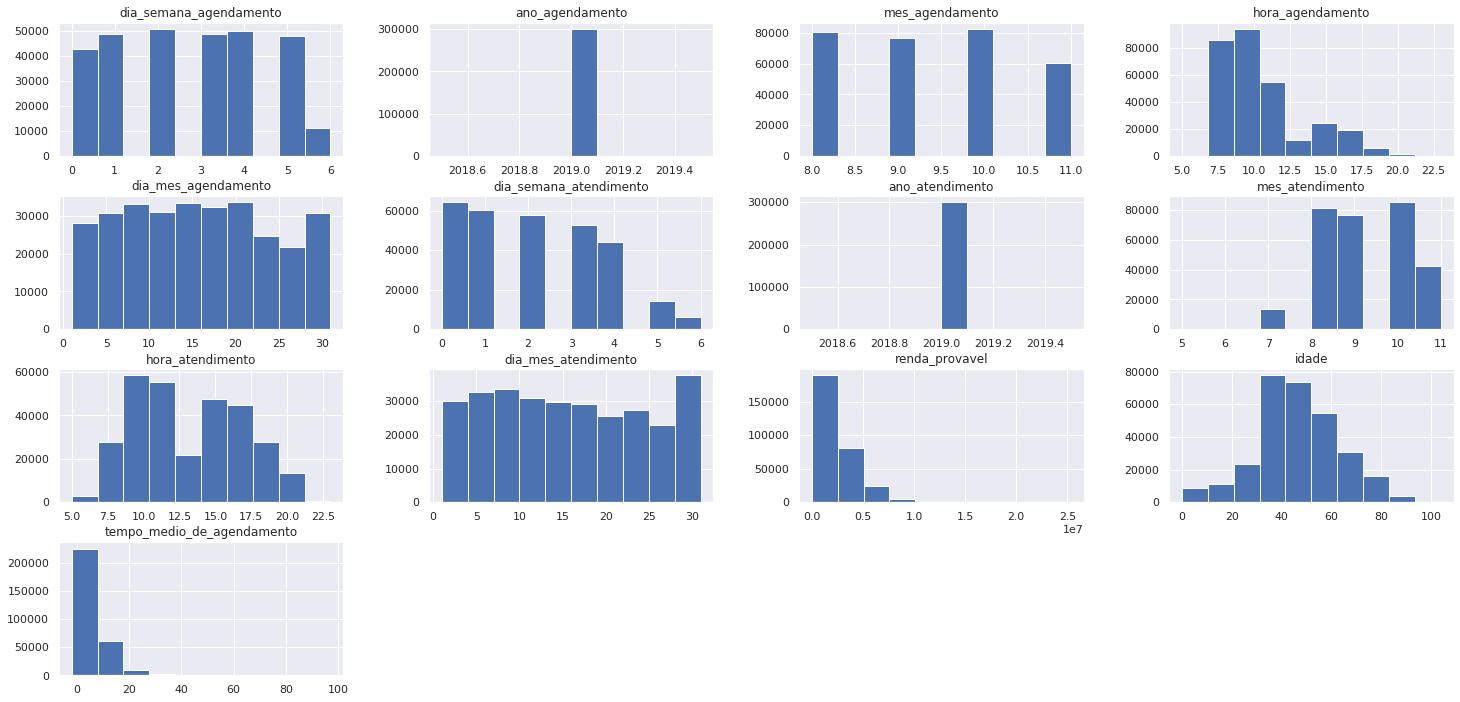

In [24]:
num_attributes.hist();

# H1: Pessoas mais novas, tendem a ter mais noshow
***Verdade***

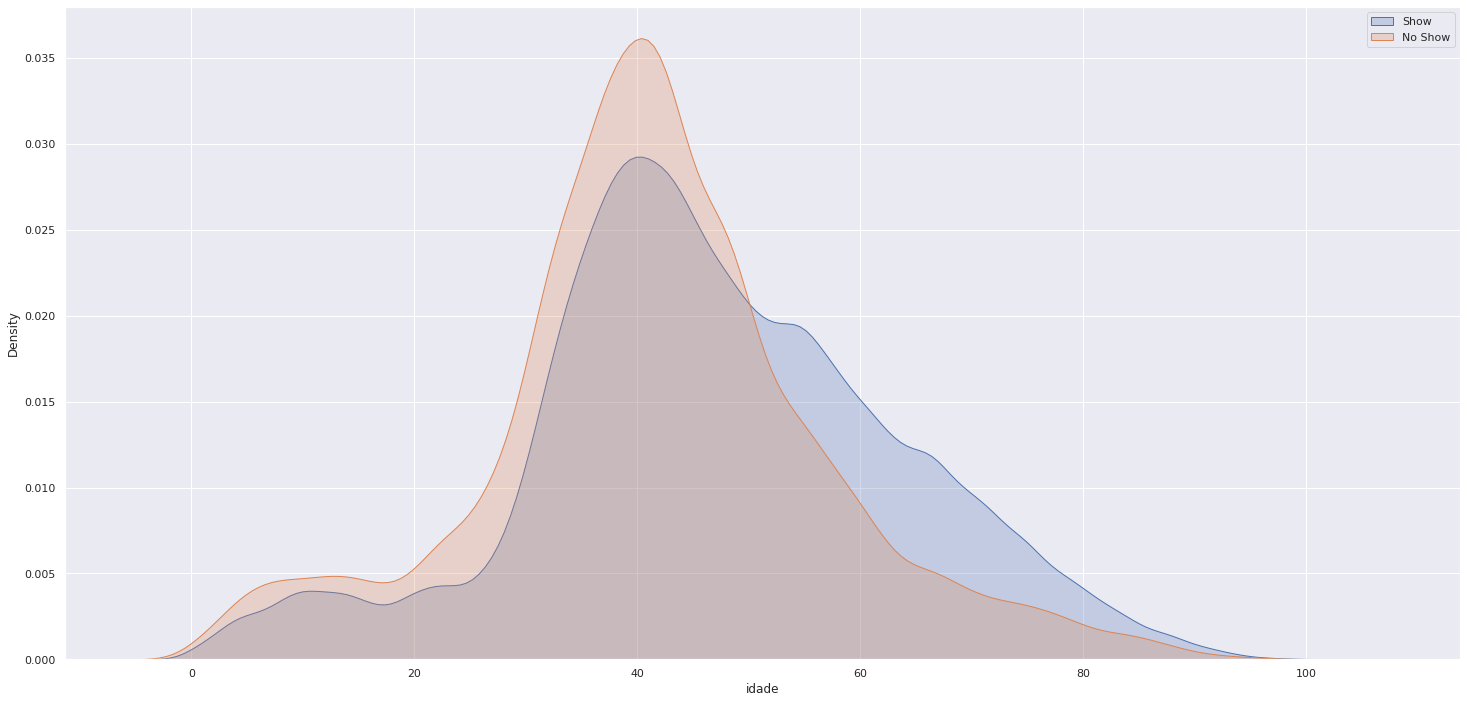

In [25]:
sns.kdeplot(df3[df3['no_show'] == 0]['idade'], label='Show', shade=True)
sns.kdeplot(df3[df3['no_show'] == 1]['idade'], label='No Show', shade=True)
plt.legend()

# H2: Renda, não deve ter efeito em noshow
***Falso***: pessoas com menor renda tendem a ter um pouco mais de noshow

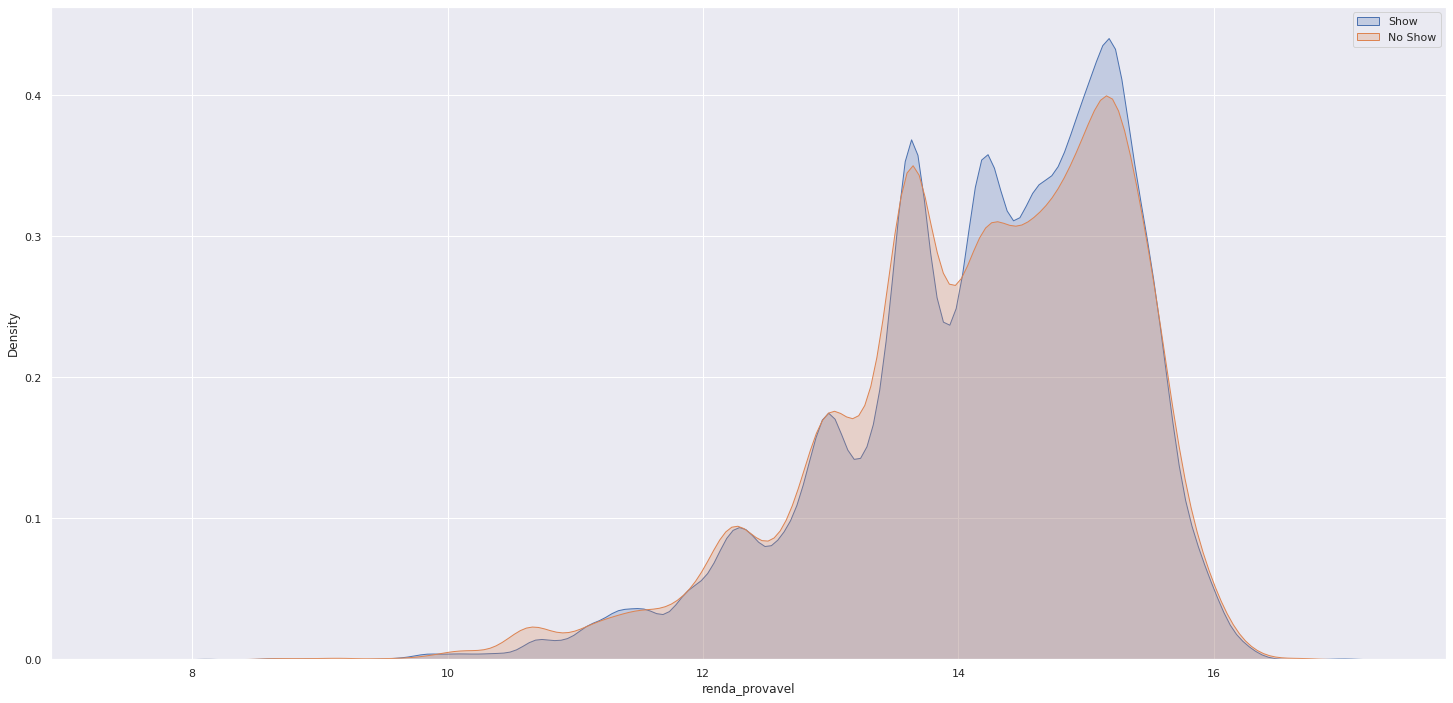

In [26]:
aux1 = df3.copy()
aux1['renda_provavel'] = df3['renda_provavel'].apply(lambda x: np.log1p(x))
aux1 = aux1[aux1['renda_provavel'] > 0]
sns.kdeplot(aux1[aux1['no_show'] == 0]['renda_provavel'], label='Show', shade=True)
sns.kdeplot(aux1[aux1['no_show'] == 1]['renda_provavel'], label='No Show', shade=True)
plt.legend()

In [27]:
aux1.head()

,dia_semana_agendamento,ano_agendamento,mes_agendamento,hora_agendamento,dia_mes_agendamento,dia_semana_atendimento,ano_atendimento,mes_atendimento,hora_atendimento,dia_mes_atendimento,secao,medico_preferencial,renda_provavel,micro_area,diretoria,cod_convenio,codigo_exame,idade,tempo_medio_de_agendamento,unidade,bairro,feminino,no_show,data_agendamento,data_atendimento,dias_ag_at
0,6,2019,8,8,18,3,2019,8,15,15,110,0,13.843927,377,7,115,465530,39.0,2,VILLA LOBOS,4218,1,0,2019-08-18 08:00:00,2019-08-15 15:00:00,2
1,2,2019,11,7,6,0,2019,11,13,4,110,0,13.843927,377,7,115,465530,39.0,1,VILLA LOBOS,4218,1,1,2019-11-06 07:00:00,2019-11-04 13:00:00,1
2,5,2019,8,8,31,3,2019,8,15,15,36,0,13.843927,377,7,115,465530,39.0,15,ITAIM,4218,1,0,2019-08-31 08:00:00,2019-08-15 15:00:00,15
3,4,2019,9,11,27,4,2019,9,8,27,110,1,13.101334,767,7,115,465530,49.0,0,HIGIENÓPOLIS,2169,1,0,2019-09-27 11:00:00,2019-09-27 08:00:00,0
4,4,2019,10,11,11,1,2019,10,17,1,110,0,10.368165,568,7,115,7244510,33.0,9,ALPHAVILLE,9638,1,0,2019-10-11 11:00:00,2019-10-01 17:00:00,9


# H3: Prazos longos entre agendamento e atendimento, tendem a ter mais noshows
**Verdade**, porém quando prazos são muito longos a distância diminui

(0, 43.28909724138234)

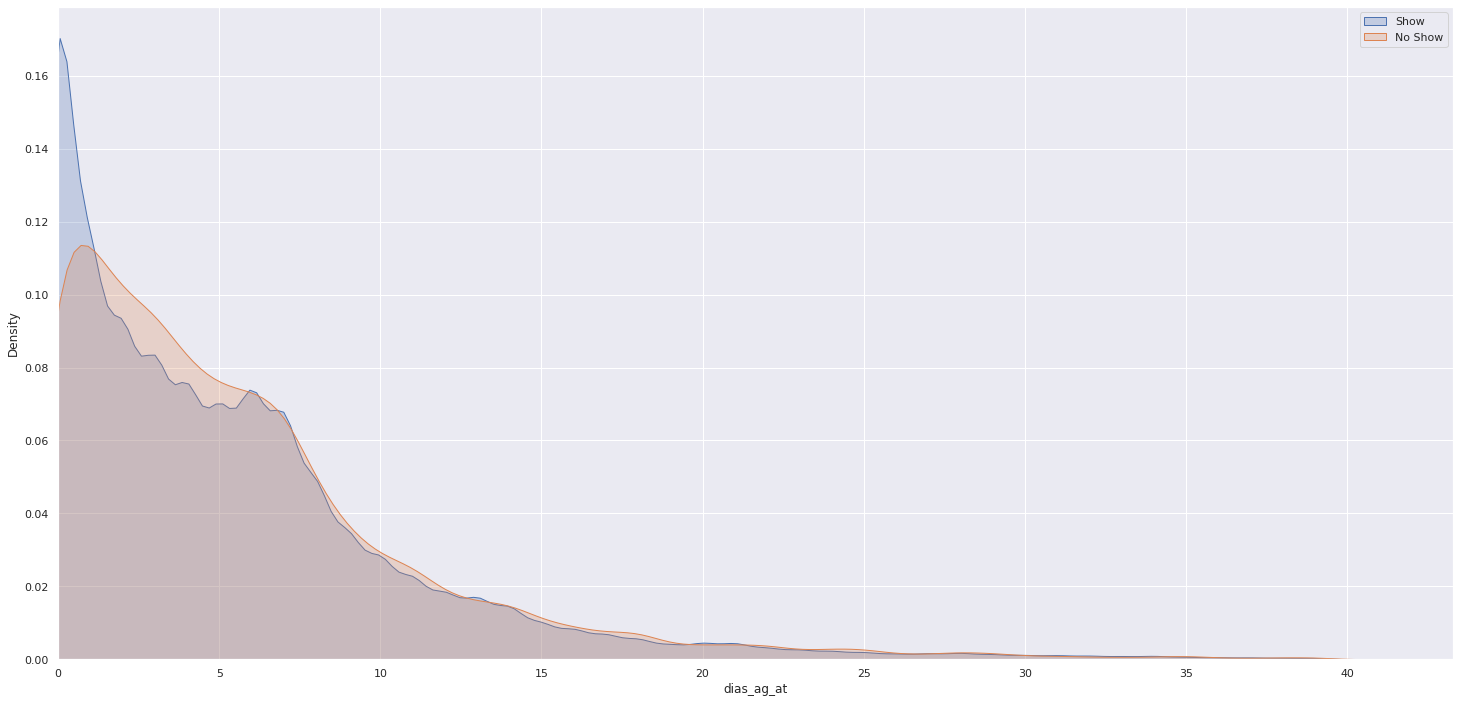

In [28]:
aux1 = df3[df3['dias_ag_at'] < 40]
sns.kdeplot(aux1[aux1['no_show'] == 0]['dias_ag_at'], label='Show', shade=True)
sns.kdeplot(aux1[aux1['no_show'] == 1]['dias_ag_at'], label='No Show', shade=True)
plt.legend()
plt.xlim(left=0)

# H4: Dia, mês ou dia da semana não deveria ter efeitos em noshow
**Falso**: apenas dia da semana e hora possui grande influência em noshow

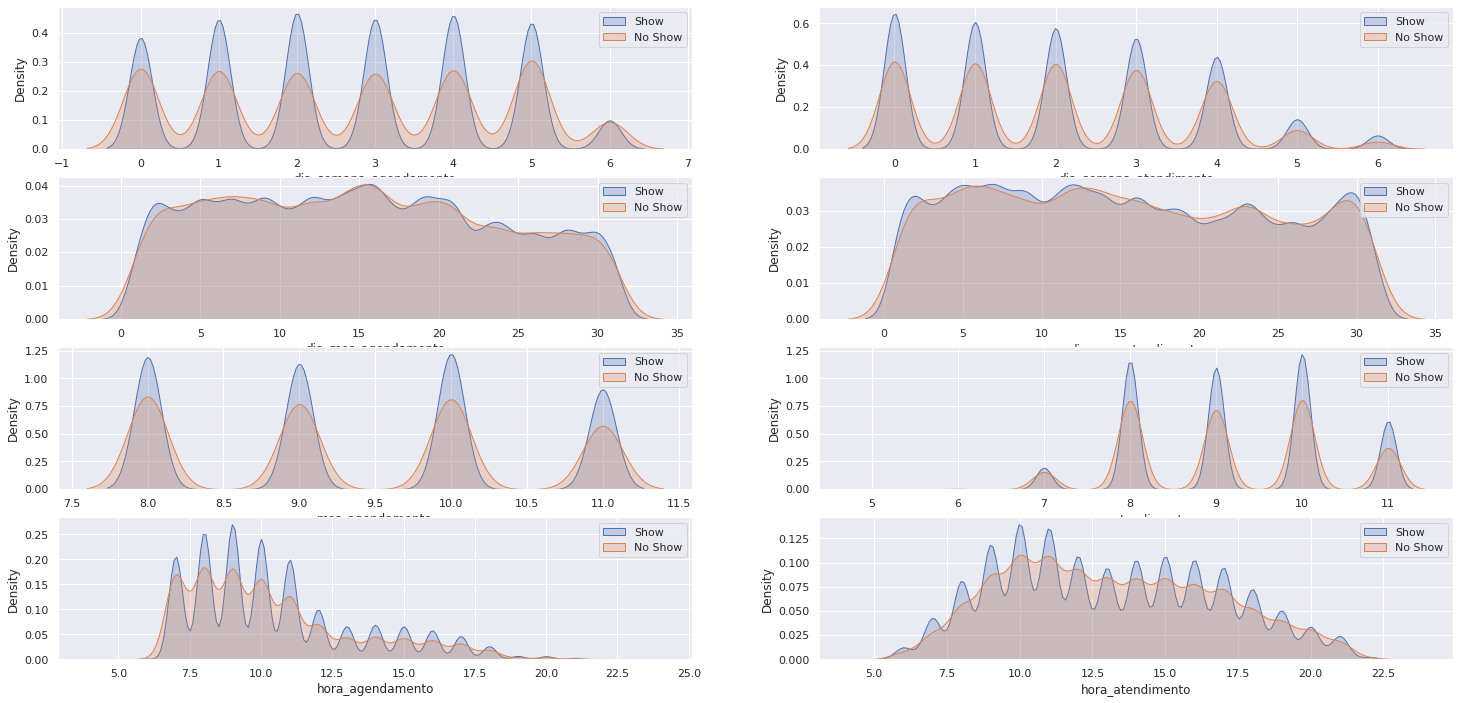

In [29]:
plt.subplot(4,2,1)
sns.kdeplot(df3[df3['no_show'] == 0]['dia_semana_agendamento'], label='Show', shade=True)
sns.kdeplot(df3[df3['no_show'] == 1]['dia_semana_agendamento'], label='No Show', shade=True)
plt.legend()

plt.subplot(4,2,2)
sns.kdeplot(df3[df3['no_show'] == 0]['dia_semana_atendimento'], label='Show', shade=True)
sns.kdeplot(df3[df3['no_show'] == 1]['dia_semana_atendimento'], label='No Show', shade=True)
plt.legend()

plt.subplot(4,2,3)
sns.kdeplot(df3[df3['no_show'] == 0]['dia_mes_agendamento'], label='Show', shade=True)
sns.kdeplot(df3[df3['no_show'] == 1]['dia_mes_agendamento'], label='No Show', shade=True)
plt.legend()

plt.subplot(4,2,4)
sns.kdeplot(df3[df3['no_show'] == 0]['dia_mes_atendimento'], label='Show', shade=True)
sns.kdeplot(df3[df3['no_show'] == 1]['dia_mes_atendimento'], label='No Show', shade=True)
plt.legend()

plt.subplot(4,2,5)
sns.kdeplot(df3[df3['no_show'] == 0]['mes_agendamento'], label='Show', shade=True)
sns.kdeplot(df3[df3['no_show'] == 1]['mes_agendamento'], label='No Show', shade=True)
plt.legend()

plt.subplot(4,2,6)
sns.kdeplot(df3[df3['no_show'] == 0]['mes_atendimento'], label='Show', shade=True)
sns.kdeplot(df3[df3['no_show'] == 1]['mes_atendimento'], label='No Show', shade=True)
plt.legend()

plt.subplot(4,2,7)
sns.kdeplot(df3[df3['no_show'] == 0]['hora_agendamento'], label='Show', shade=True)
sns.kdeplot(df3[df3['no_show'] == 1]['hora_agendamento'], label='No Show', shade=True)
plt.legend()

plt.subplot(4,2,8)
sns.kdeplot(df3[df3['no_show'] == 0]['hora_atendimento'], label='Show', shade=True)
sns.kdeplot(df3[df3['no_show'] == 1]['hora_atendimento'], label='No Show', shade=True)
plt.legend()

# 4. Prepare data

In [30]:
df4 = df3.copy()

## 4.1 Normalização da idade
Por ser a única variável que tem aspecto normal, ela será normalizada

In [31]:
idade_media = float(m[m['attributes'] == 'idade']['mean'])
idade_desvio = float(m[m['attributes'] == 'idade']['std'])

In [32]:
df4['idade'] = df4['idade'].apply(lambda x: (x-idade_media)/idade_desvio)

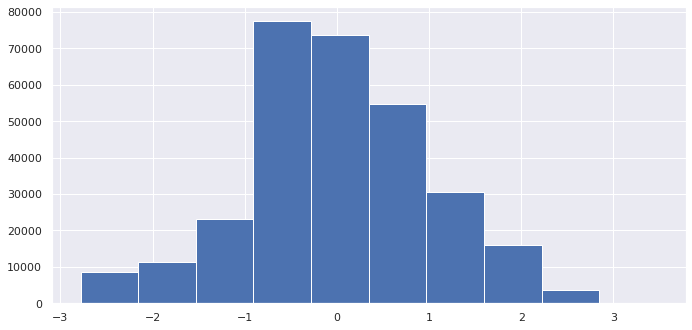

In [33]:
plt.subplot(2,2,1)
df4['idade'].hist()

## 4.2 Escalar atributos

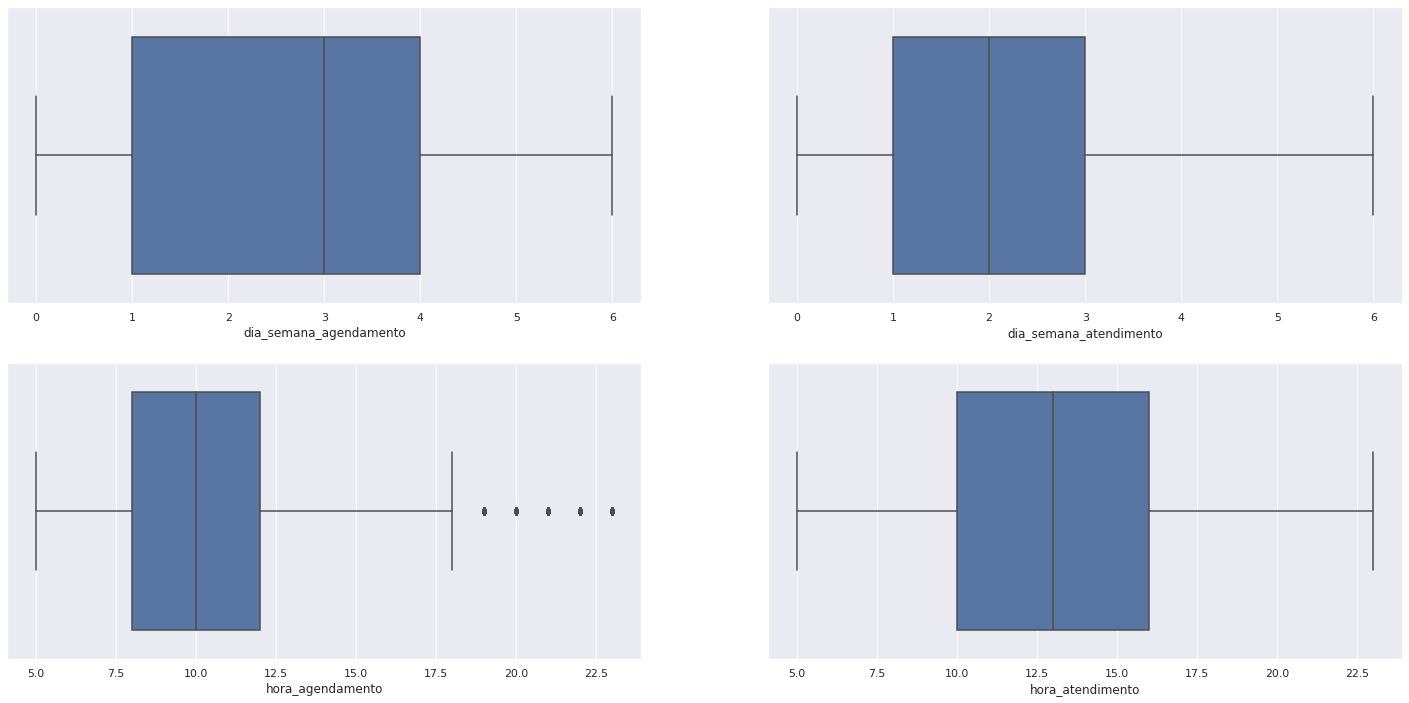

In [34]:
rs = RobustScaler()
mns = MinMaxScaler()

plt.subplot(2,2,1)
sns.boxplot(df4['dia_semana_agendamento'])

plt.subplot(2,2,2)
sns.boxplot(df4['dia_semana_atendimento'])

plt.subplot(2,2,3)
sns.boxplot(df4['hora_agendamento'])

plt.subplot(2,2,4)
sns.boxplot(df4['hora_atendimento'])

In [35]:
# dia_semana_agendamento
df4[['dia_semana_agendamento']] = rs.fit_transform(df4[['dia_semana_agendamento']].values)

# dia_semana_atendimento
df4[['dia_semana_atendimento']] = rs.fit_transform(df4[['dia_semana_atendimento']].values)

# hora_agendamento
df4[['hora_agendamento']] = rs.fit_transform(df4[['hora_agendamento']].values)

# hora_atendimento
df4[['hora_atendimento']] = rs.fit_transform(df4[['hora_atendimento']].values)

# 4.2.1 Transformação logaritimica

In [36]:
df4['dias_ag_at'] = df4['dias_ag_at'].apply(lambda x: np.log1p(x))

df4['renda_provavel'] = df4['renda_provavel'].apply(lambda x: np.log1p(x))

## 4.3 Encoding

In [37]:
# store_type - LABEL ENCONDING
le = LabelEncoder()
df4['secao'] = le.fit_transform(df4['secao'])
df4['micro_area'] = le.fit_transform(df4['micro_area'])
df4['diretoria'] = le.fit_transform(df4['diretoria'])
df4['cod_convenio'] = le.fit_transform(df4['cod_convenio'])
df4['codigo_exame'] = le.fit_transform(df4['codigo_exame'])
df4['unidade'] = le.fit_transform(df4['unidade'])
df4['bairro'] = le.fit_transform(df4['bairro'])

In [38]:
df4.head()

,dia_semana_agendamento,ano_agendamento,mes_agendamento,hora_agendamento,dia_mes_agendamento,dia_semana_atendimento,ano_atendimento,mes_atendimento,hora_atendimento,dia_mes_atendimento,secao,medico_preferencial,renda_provavel,micro_area,diretoria,cod_convenio,codigo_exame,idade,tempo_medio_de_agendamento,unidade,bairro,feminino,no_show,data_agendamento,data_atendimento,dias_ag_at
0,1.000000,2019,8,-0.50,18,0.5,2019,8,0.333333,15,18,0,13.843927,220,1,4,67,-0.435768,2,33,1415,1,0,2019-08-18 08:00:00,2019-08-15 15:00:00,1.098612
1,-0.333333,2019,11,-0.75,6,-1.0,2019,11,0.000000,4,18,0,13.843927,220,1,4,67,-0.435768,1,33,1415,1,1,2019-11-06 07:00:00,2019-11-04 13:00:00,0.693147
2,0.666667,2019,8,-0.50,31,0.5,2019,8,0.333333,15,4,0,13.843927,220,1,4,67,-0.435768,15,14,1415,1,0,2019-08-31 08:00:00,2019-08-15 15:00:00,2.772589
3,0.333333,2019,9,0.25,27,1.0,2019,9,-0.833333,27,18,1,13.101334,435,1,4,67,0.165725,0,12,700,1,0,2019-09-27 11:00:00,2019-09-27 08:00:00,0.000000
4,0.333333,2019,10,0.25,11,-0.5,2019,10,0.666667,1,18,0,10.368165,326,1,4,379,-0.796663,9,0,3387,1,0,2019-10-11 11:00:00,2019-10-01 17:00:00,2.302585


# 5 Seleção de atributos

In [39]:
df5 = df4.copy()

In [40]:
cols_drop = ['ano_agendamento', 'mes_agendamento', 'dia_mes_agendamento',
             'ano_atendimento', 'mes_atendimento', 'dia_mes_atendimento',
             'data_agendamento', 'data_atendimento']
df5 = df5.drop(cols_drop, axis=1)

In [41]:
df5.head()

,dia_semana_agendamento,hora_agendamento,dia_semana_atendimento,hora_atendimento,secao,medico_preferencial,renda_provavel,micro_area,diretoria,cod_convenio,codigo_exame,idade,tempo_medio_de_agendamento,unidade,bairro,feminino,no_show,dias_ag_at
0,1.000000,-0.50,0.5,0.333333,18,0,13.843927,220,1,4,67,-0.435768,2,33,1415,1,0,1.098612
1,-0.333333,-0.75,-1.0,0.000000,18,0,13.843927,220,1,4,67,-0.435768,1,33,1415,1,1,0.693147
2,0.666667,-0.50,0.5,0.333333,4,0,13.843927,220,1,4,67,-0.435768,15,14,1415,1,0,2.772589
3,0.333333,0.25,1.0,-0.833333,18,1,13.101334,435,1,4,67,0.165725,0,12,700,1,0,0.000000
4,0.333333,0.25,-0.5,0.666667,18,0,10.368165,326,1,4,379,-0.796663,9,0,3387,1,0,2.302585


## 5.1 Separação da base de treino e teste

In [42]:
data_y = df5['no_show']

x_columns = df5.columns.to_list()
x_columns.remove('no_show')
data_x = df5[x_columns]

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=0.1, random_state=32)

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# 6 Modelos de machine learning

# 6.1 Simples KNN

In [43]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

y_hat_knn = knn.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_hat_knn)
print(round(accuracy,4))

0.8829


In [44]:
df_knn = pd.DataFrame(data=np.array([y_hat_knn, np.array(y_test)]).T, columns=["predicao", "valor_real"])
df_knn.head()

,predicao,valor_real
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [45]:
noshow_errado = df_knn[(df_knn['predicao'] == 1) & (df_knn['valor_real'] == 0)].count()[0]
noshow_certo = df_knn[(df_knn['predicao'] == 1) & (df_knn['valor_real'] == 1)].count()[0]
show_errado = df_knn[(df_knn['predicao'] == 0) & (df_knn['valor_real'] == 1)].count()[0]
show_certo = df_knn[(df_knn['predicao'] == 0) & (df_knn['valor_real'] == 0)].count()[0]

In [46]:
df_algorithms = pd.DataFrame({
    'noshow_errado':noshow_errado,
    'noshow_certo':noshow_certo,
    'show_errado':show_errado,
    'show_certo':show_certo,
        }, index=['baseline: KNN'])
df_algorithms

,noshow_errado,noshow_certo,show_errado,show_certo
baseline: KNN,308,407,3198,26037


## 6.2 XGBoost

In [47]:
# model
model_xgb = xgb.XGBClassifier(base_score=0.7, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=30,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, subsample=1).fit(x_train, y_train)

# prediction
y_hat_xgb = model_xgb.predict(x_test)

# performance
accuracy = metrics.accuracy_score(np.array(y_test), y_hat_xgb)
print(round(accuracy,4))

df_xgb = pd.DataFrame(data=np.array([y_hat_xgb, np.array(y_test)]).T, columns=["predicao", "valor_real"])

noshow_errado = df_xgb[(df_xgb['predicao'] == 1) & (df_xgb['valor_real'] == 0)].count()[0]
noshow_certo = df_xgb[(df_xgb['predicao'] == 1) & (df_xgb['valor_real'] == 1)].count()[0]
show_errado = df_xgb[(df_xgb['predicao'] == 0) & (df_xgb['valor_real'] == 1)].count()[0]
show_certo = df_xgb[(df_xgb['predicao'] == 0) & (df_xgb['valor_real'] == 0)].count()[0]

df_algorithms = df_algorithms.append(
    pd.DataFrame({
    'noshow_errado':noshow_errado,
    'noshow_certo':noshow_certo,
    'show_errado':show_errado,
    'show_certo':show_certo,
        }, index=['XDGBoost'])
    )

0.9333


In [48]:
df_algorithms

,noshow_errado,noshow_certo,show_errado,show_certo
baseline: KNN,308,407,3198,26037
XDGBoost,202,1810,1795,26143


## 6.2.1 Validação Cross-over

In [52]:
kf = KFold(n_splits=3)
data_x = np.array(data_x)
data_y = np.array(data_y)
kf.get_n_splits(data_x)

i = 1
for train_index, test_index in kf.split(data_x):
    x_train, x_test = data_x[train_index], data_x[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]

    # model
    model_xgb = xgb.XGBClassifier(base_score=0.7, colsample_bylevel=1, colsample_bytree=1,
           gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=30,
           min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
           objective='binary:logistic', reg_alpha=0, reg_lambda=1,
           scale_pos_weight=1, seed=0, subsample=1).fit(x_train, y_train)

    # prediction
    y_hat_xgb = model_xgb.predict(x_test)

    # performance
    accuracy = metrics.accuracy_score(np.array(y_test), y_hat_xgb)
    print('\nTrain index:' + str(i) + ' - accuracy:' + str(round(accuracy,4)))

    df_xgb = pd.DataFrame(data=np.array([y_hat_xgb, np.array(y_test)]).T, columns=["predicao", "valor_real"])

    noshow_errado = df_xgb[(df_xgb['predicao'] == 1) & (df_xgb['valor_real'] == 0)].count()[0]
    noshow_certo = df_xgb[(df_xgb['predicao'] == 1) & (df_xgb['valor_real'] == 1)].count()[0]
    show_errado = df_xgb[(df_xgb['predicao'] == 0) & (df_xgb['valor_real'] == 1)].count()[0]
    show_certo = df_xgb[(df_xgb['predicao'] == 0) & (df_xgb['valor_real'] == 0)].count()[0]

    df_algorithms = df_algorithms.append(
        pd.DataFrame({
        'noshow_errado':noshow_errado,
        'noshow_certo':noshow_certo,
        'show_errado':show_errado,
        'show_certo':show_certo,
            }, index=['XDGBoost_cross_validation '+str(i)])
        )
    i += 1


Train index:1 - accuracy:0.8926

Train index:2 - accuracy:0.887

Train index:3 - accuracy:0.8505


In [53]:
df_algorithms

,noshow_errado,noshow_certo,show_errado,show_certo
baseline: KNN,308,407,3198,26037
XDGBoost,202,1810,1795,26143
XDGBoost_cross_validation 1,495,157,10222,88958
XDGBoost_cross_validation 2,620,214,10660,88338
XDGBoost_cross_validation 3,877,324,14045,84586


A validação cruzada não trouxe bons resultados mesmo com 'k' baixo possivelmente não haver base de dados suficiente para treinar o modelo.
Desta forma, avaliaremos alterando random state do split

In [54]:
for i in [1, 21, 32, 40]:
    data_y = df5['no_show']

    x_columns = df5.columns.to_list()
    x_columns.remove('no_show')
    data_x = df5[x_columns]

    x_train, x_test, y_train, y_test = train_test_split(data_x, data_y,
                                                        test_size=0.1, random_state=i)

    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    # model
    model_xgb = xgb.XGBClassifier(base_score=0.7, colsample_bylevel=1, colsample_bytree=1,
           gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=30,
           min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
           objective='binary:logistic', reg_alpha=0, reg_lambda=1,
           scale_pos_weight=1, seed=0, subsample=1).fit(x_train, y_train)

    # prediction
    y_hat_xgb = model_xgb.predict(x_test)

    # performance
    accuracy = metrics.accuracy_score(np.array(y_test), y_hat_xgb)
    print('\nTrain random state:' + str(i) + ' - accuracy:' + str(round(accuracy,4)))

    df_xgb = pd.DataFrame(data=np.array([y_hat_xgb, np.array(y_test)]).T, columns=["predicao", "valor_real"])

    noshow_errado = df_xgb[(df_xgb['predicao'] == 1) & (df_xgb['valor_real'] == 0)].count()[0]
    noshow_certo = df_xgb[(df_xgb['predicao'] == 1) & (df_xgb['valor_real'] == 1)].count()[0]
    show_errado = df_xgb[(df_xgb['predicao'] == 0) & (df_xgb['valor_real'] == 1)].count()[0]
    show_certo = df_xgb[(df_xgb['predicao'] == 0) & (df_xgb['valor_real'] == 0)].count()[0]

    df_algorithms = df_algorithms.append(
        pd.DataFrame({
        'noshow_errado':noshow_errado,
        'noshow_certo':noshow_certo,
        'show_errado':show_errado,
        'show_certo':show_certo,
            }, index=['XDGBoost_random_state '+str(i)])
        )
    i += 1


Train random state:1 - accuracy:0.9348

Train random state:21 - accuracy:0.9336

Train random state:32 - accuracy:0.9333

Train random state:40 - accuracy:0.9333


In [55]:
df_algorithms

,noshow_errado,noshow_certo,show_errado,show_certo
baseline: KNN,308,407,3198,26037
XDGBoost,202,1810,1795,26143
XDGBoost_cross_validation 1,495,157,10222,88958
XDGBoost_cross_validation 2,620,214,10660,88338
XDGBoost_cross_validation 3,877,324,14045,84586
XDGBoost_random_state 1,201,1795,1753,26201
XDGBoost_random_state 21,220,1753,1769,26208
XDGBoost_random_state 32,202,1810,1795,26143
XDGBoost_random_state 40,226,1807,1773,26144


In [66]:
mean_ns_baseline = np.mean([
    df_algorithms['noshow_certo']['baseline: KNN'],
    ]) / df_knn['valor_real'].sum()

mean_ns_xgb = np.mean([
    df_algorithms['noshow_certo']['XDGBoost_random_state 1'],
    df_algorithms['noshow_certo']['XDGBoost_random_state 21'],
    df_algorithms['noshow_certo']['XDGBoost_random_state 32'],
    df_algorithms['noshow_certo']['XDGBoost_random_state 40'],
    ]) / df_xgb['valor_real'].sum()

In [70]:
print('O acerto do modelo KNN acerta:{} % dos noshows'.format(round(100*mean_ns_baseline, 2)))
print('O acerto do modelo XDGBoost em média acerta: {} % dos noshows'.format(round(100*mean_ns_xgb, 2)))

O acerto do modelo KNN acerta:11.29 % dos noshows
O acerto do modelo XDGBoost em média acerta: 50.03 % dos noshows


## 7 Conclusões

- XDGBoost proposto com os dados usados consegue-se detectar 50% dos casos de "no shows" ao contrário dos 11% em modelos mais simples.

- Cross validation não traz bons resultados, porém provavelmente pela pequena quantidade de dados

- 